# Fake News Challenge - Stance Detection

First Steps, here we:

* Install any important libaries
* Build stop word list
* import all used libaries including 'functions' which contains handmade functions and classes
* Read the data CSVs
* Split the data into a 90/10 split
* Tokenize and filter out the stop words

In [1]:
#!pip install keras
#!pip install sklearn
#!pip install nltk
#!pip install seaborn
#!pip install lightgbm

In [2]:
stop_words = [
        "a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along",
        "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
        "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be",
        "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
        "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "co",
        "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
        "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
        "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill", "find", "fire", "first", "five", "for",
        "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
        "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself",
        "him", "himself", "his", "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed", "interest",
        "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
        "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
        "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "nobody", "now", "nowhere",
        "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours",
        "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
        "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some",
        "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take",
        "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
        "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though",
        "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve",
        "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what",
        "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon",
        "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will",
        "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
        ]

In [4]:
import os
from functions import *
import numpy as np
import sklearn
import pandas as pd
import csv
from collections import defaultdict
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import lightgbm
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


In [5]:
train, valid = Data('train_bodies.csv', 'train_stances.csv', 0.1).split_data()

validation = pd.DataFrame(valid, columns= ["headline", "body", "stance"])
training = pd.DataFrame(train, columns= ["headline", "body", "stance"])

for i,j in zip(validation["stance"].value_counts(), training["stance"].value_counts()):
    print("Class Values in Validation set:                 ", i/j)

print("Total proportion of instances in Validation set:", 1/9)

Class Values in Validation set:                  0.11116178661558576
Class Values in Validation set:                  0.11432145090681677
Class Values in Validation set:                  0.10053859964093358
Class Values in Validation set:                  0.12299465240641712
Total proportion of instances in Validation set: 0.1111111111111111


In [6]:
stop_words = stop_words

training["body"] = [training["body"][i].split() for i in range(len(training))]
training["headline"] = [training["headline"][i].split() for i in range(len(training))]
training["body"] = training["body"].apply(lambda x: [item for item in x if item not in stop_words])
training["headline"] = training["headline"].apply(lambda x: [item for item in x if item not in stop_words])

validation["body"] = [validation["body"][i].split() for i in range(len(validation))]
validation["headline"] = [validation["headline"][i].split() for i in range(len(validation))]
validation["body"] = validation["body"].apply(lambda x: [item for item in x if item not in stop_words])
validation["headline"] = validation["headline"].apply(lambda x: [item for item in x if item not in stop_words])

In [7]:
training.head()

,headline,body,stance
0,"[Islamist, terrorists, Jabhat, Ansar, al-Deen,...","[The, Force, little, sooner, expected, latest,...",unrelated
1,"[Boko, Haram, denies, cease-fire,, leader, say...","[A, trip, Bali, turned, Dylan, Thomas, real-li...",unrelated
2,"[YPG, Confirms:, Gill, Rosenberg, Not, Capture...","[An, alleged, attempted, rapist, India, receiv...",unrelated
3,"[Second, person, rushed, hospital, Ebola, symp...","[A, 31-year-old, Canadian-Israeli, woman, trav...",unrelated
4,"[Watch:, ISIS, Claims, Have, Captured, U.S., A...","[Poverty-stricken, parents, took, streets, auc...",unrelated


# TF-IDF and Ngrams

Here we start to introduce features, but first we must use TF-IDF in order to vectorize our headline/body pairs, then we can use these vectors to take distances and build further features. Furthermore, the vocab has been build using the entire dataset, this helps with any incosistencies when using the full TF-IDF data in the deep learning model.

In [8]:
def build_vocab(a, b):
    corpus = a+b
    freq = defaultdict(float)
    for doc in corpus:
        unique = set(doc)
        for unique_word in unique:
            freq[unique_word] +=1.0

    filtered_words = {k:v for (k,v) in freq.items() if (v/len(corpus)) > 0.01 and (v/len(corpus))<0.75} 
    vocab = set(filtered_words)
    return vocab

training_vocab = build_vocab(training['headline'], training['body'])
valid_vocab = build_vocab(validation['headline'], validation['body'])
vocab = training_vocab.union(valid_vocab)

In [9]:
print("Words in Vocab:", len(vocab))

Words in Vocab: 3529


In [10]:
training['tfidf_headline'] = TFIDF(training['headline'] , vocab).compute_tf_idf()
training['tfidf_body'] = TFIDF(training['body'] , vocab).compute_tf_idf()

In [11]:
training.head()

,headline,body,stance,tfidf_headline,tfidf_body
0,"[Islamist, terrorists, Jabhat, Ansar, al-Deen,...","[The, Force, little, sooner, expected, latest,...",unrelated,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0198030628459, 0.0, 0.0, 0.0, 0...."
1,"[Boko, Haram, denies, cease-fire,, leader, say...","[A, trip, Bali, turned, Dylan, Thomas, real-li...",unrelated,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[YPG, Confirms:, Gill, Rosenberg, Not, Capture...","[An, alleged, attempted, rapist, India, receiv...",unrelated,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[Second, person, rushed, hospital, Ebola, symp...","[A, 31-year-old, Canadian-Israeli, woman, trav...",unrelated,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0190552..."
4,"[Watch:, ISIS, Claims, Have, Captured, U.S., A...","[Poverty-stricken, parents, took, streets, auc...",unrelated,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [12]:
training['body_ngrams'] = training.apply(lambda x:[Ngram(word, x['body'], vocab) for word in x['body']], axis = 1)
training['headline_ngrams'] = training.apply(lambda x:[Ngram(word, x['headline'], vocab) for word in x['body']], axis = 1)

# Distances and Other features

Using the vectorized headline/body pairs and the ngrams calculated using unigram laplace smoothing, we can start to find features that might help with out regression later. Here find Cosine, Manhattan, Jaccard and KL Divergence. These are also plotted below.

In [13]:
training["cosine"] = training.apply(lambda x:get_cosine(x['tfidf_headline'][0], x['tfidf_body'][0]), axis = 1)
training["manhattan"] = training.apply(lambda x:manhattan(x['tfidf_headline'][0], x['tfidf_body'][0]), axis = 1)
training["jaccard"] = training.apply(lambda x:jaccard_distance(x['tfidf_headline'][0], x['tfidf_body'][0]), axis = 1)
training["KLD"] = training.apply(lambda x:KLD(x['headline_ngrams'], x['body_ngrams']), axis = 1)


/home/ubuntu/Untitled Folder/functions.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2.T) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


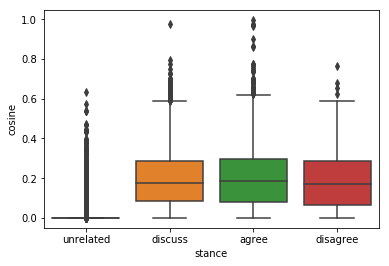

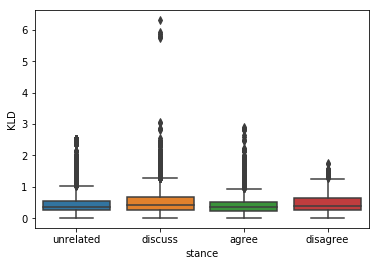

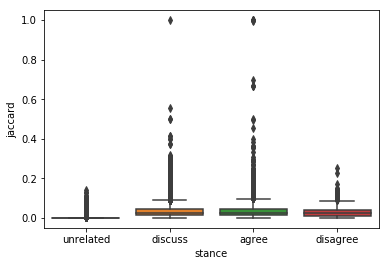

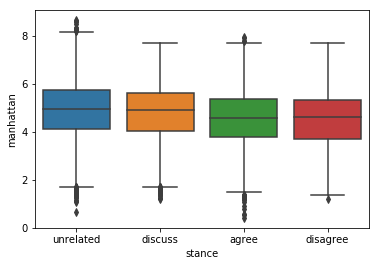

In [14]:
sns.boxplot(x="stance", y="cosine", data=training[['cosine','stance' ]])
plt.show()
sns.boxplot(x="stance", y="KLD", data=training[['KLD','stance' ]])
plt.show()
sns.boxplot(x="stance", y="jaccard", data=training[['jaccard','stance' ]])
plt.show()
sns.boxplot(x="stance", y="manhattan", data=training[['manhattan','stance' ]])
plt.show()

### Common Ngrams

Inspired by Cisco-Talos, I have chosen to implement common Ngrams between the headline/body pair, these have proven to be very helpful for classifying the dataset. I have left out the plots of 4,5,6grams to try and leave the notebook uncluttered. 

In [15]:
training["bigrams"] = training.apply(lambda x:common_ngrams(x['body'], x['headline'], 2), axis = 1)
training["trigrams"] = training.apply(lambda x:common_ngrams(x['body'], x['headline'], 3), axis = 1)
training["fourgrams"] = training.apply(lambda x:common_ngrams(x['body'], x['headline'], 4), axis = 1)
training["fivegrams"] = training.apply(lambda x:common_ngrams(x['body'], x['headline'], 5), axis = 1)
training["sixgrams"] = training.apply(lambda x:common_ngrams(x['body'], x['headline'], 6), axis = 1)
training["sevengrams"] = training.apply(lambda x:common_ngrams(x['body'], x['headline'], 7), axis = 1)

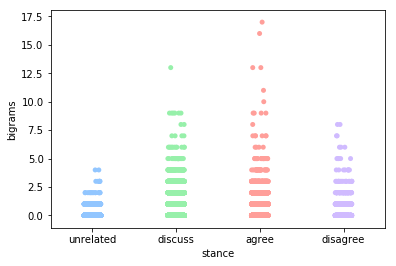

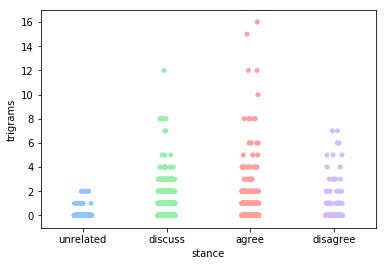

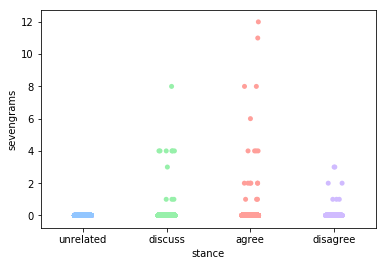

In [16]:
sns.stripplot(x="stance", y="bigrams", data=training[['bigrams','stance' ]], jitter=True, palette="pastel");
plt.show()
sns.stripplot(x="stance", y="trigrams", data=training[['trigrams','stance' ]], jitter=True, palette="pastel");
plt.show()
# sns.stripplot(x="stance", y="fourgrams", data=training[['fourgrams','stance' ]], jitter=True, palette="pastel");
# plt.show()
# sns.stripplot(x="stance", y="fivegrams", data=training[['fivegrams','stance' ]], jitter=True, palette="pastel");
# plt.show()
# sns.stripplot(x="stance", y="sixgrams", data=training[['sixgrams','stance' ]], jitter=True, palette="pastel");
# plt.show()
sns.stripplot(x="stance", y="sevengrams", data=training[['sevengrams','stance' ]], jitter=True, palette="pastel");
plt.show()

## Prepare the Validation Set

So far we have prepared the training set for regression and our other classifiers. However, we wish to test our classifiers on a validation set, we now prepare the data so that we can use this validation set.

In [17]:
validation['tfidf_headline'] =  TFIDF(validation['headline'] ,vocab).compute_tf_idf()
validation['tfidf_body'] = TFIDF(validation['body'] ,vocab).compute_tf_idf()
validation["bigrams"] = validation.apply(lambda x:common_ngrams(x['body'], x['headline'], 2), axis = 1)
validation["trigrams"] = validation.apply(lambda x:common_ngrams(x['body'], x['headline'], 3), axis = 1)
validation["fourgrams"] = validation.apply(lambda x:common_ngrams(x['body'], x['headline'], 4), axis = 1)
validation["fivegrams"] = validation.apply(lambda x:common_ngrams(x['body'], x['headline'], 5), axis = 1)
validation["sixgrams"] = validation.apply(lambda x:common_ngrams(x['body'], x['headline'], 6), axis = 1)
validation["sevengrams"] = validation.apply(lambda x:common_ngrams(x['body'], x['headline'], 7), axis = 1)
validation["cosine"] = validation.apply(lambda x:get_cosine(x['tfidf_headline'][0], x['tfidf_body'][0]), axis = 1)
validation["manhattan"] = validation.apply(lambda x:manhattan(x['tfidf_headline'][0], x['tfidf_body'][0]), axis = 1)
validation["jaccard"] = validation.apply(lambda x:jaccard_distance(x['tfidf_headline'][0], x['tfidf_body'][0]), axis = 1)
validation['body_ngrams'] = validation.apply(lambda x:[Ngram(word, x['body'], vocab) for word in x['body']], axis = 1)
validation['headline_ngrams'] = validation.apply(lambda x:[Ngram(word, x['headline'], vocab) for word in x['body']], axis = 1)
validation["KLD"] = validation.apply(lambda x:KLD(x['headline_ngrams'], x['body_ngrams']), axis = 1)

/home/ubuntu/Untitled Folder/functions.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2.T) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


In [18]:
X = [training["jaccard"].fillna(0),
     training['cosine'].fillna(0), 
     training["bigrams"].fillna(0),
     training["trigrams"].fillna(0), 
     training["fourgrams"].fillna(0)]
X = np.array(X)
X = X.T

bias = np.ones((np.shape(X)[0],1))

X = np.hstack((bias, X))

label_values = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}

Y = [label_values[training["stance"][i]] for i in range(len(training))]
Y = np.array(Y)
Y.shape, X.shape

((44974,), (44974, 6))

In [19]:
valid_X = [validation["jaccard"].fillna(0),
           validation['cosine'].fillna(0), 
           validation["bigrams"].fillna(0),
           validation["trigrams"].fillna(0), 
           validation["fourgrams"].fillna(0)]
valid_X = np.array(valid_X)
valid_X = valid_X.T

bias = np.ones((np.shape(valid_X)[0],1))

valid_X = np.hstack((bias, valid_X))

label_values = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}

valid_Y = [label_values[validation["stance"][i]] for i in range(len(validation))]
valid_Y = np.array(valid_Y)
valid_Y.shape, valid_X.shape

((4998,), (4998, 6))

# Regression

Here we take all of our preprocessed data and use it to classify the data. The models implemented here are:

* Linear Regression
* Logistic Regression


In [20]:
model = Regression(6, 'linear', 0.01, 100)

model.train_model(X,Y)

Iteration: 0
Loss: 160957.415657
Iteration: 1
Loss: 157622.127146


KeyboardInterrupt: 

In [ ]:
predictions = model.predict(valid_X)
predictions = predictions[:,0]
correct_pred = np.equal(np.round(predictions), valid_Y)
accuracy = np.mean(correct_pred)

print(accuracy)

In [ ]:
class0, class1, class2, class3 = 1 * (Y == 0), 1 * (Y == 1), 1 * (Y == 2), 1 * (Y == 3)
model1 = Regression(6, "logistic", 0.01, 20)
model1.train_model(X, class0)
model2 = Regression(6, "logistic", 0.01, 20)
model2.train_model(X, class1)
model3 = Regression(6, "logistic", 0.01, 20)
model3.train_model(X, class2)
model4 = Regression(6, "logistic", 0.01, 20)
model4.train_model(X, class3)

In [ ]:
v_class1, v_class2, v_class3, v_class4 =1*(valid_Y == 0),1*(valid_Y == 1),1*(valid_Y == 2),1*(valid_Y == 3)
predictions1 = model1.predict(valid_X)
predictions1 = predictions1[:,0]
correct_pred = np.equal(np.round(predictions1), v_class1)
accuracy = np.mean(correct_pred)
print(accuracy)
predictions2 = model2.predict(valid_X)
predictions2 = predictions2[:,0]
correct_pred = np.equal(np.round(predictions2), v_class2)
accuracy = np.mean(correct_pred)
print(accuracy)
predictions3 = model3.predict(valid_X)
predictions3 = predictions1[:,0]
correct_pred = np.equal(np.round(predictions3), v_class3)
accuracy = np.mean(correct_pred)
print(accuracy)
predictions4 = model4.predict(valid_X)
predictions4 = predictions4[:,0]
correct_pred = np.equal(np.round(predictions4), v_class4)
accuracy = np.mean(correct_pred)
print(accuracy)

In [ ]:
prob_matrix = np.concatenate((predictions1, predictions2, predictions3, predictions4), axis=1)
final_classification = np.reshape(np.asarray(np.argmax(prob_matrix, axis=1)), (len(np.argmax(prob_matrix, axis=1))), axis=1)

In [ ]:
f_score(final_classification, valid_Y)

# Further Models

* Neural Networks
* LightGBM Gradient Boosted Trees

In [22]:
tfidf_body = np.array([xi for xi in training['tfidf_body'].get_values()])[:,0,:]
tfidf_headline = np.array([xi for xi in training['tfidf_headline'].get_values()])[:,0,:]

tfidf = np.hstack((tfidf_body,tfidf_headline))

deep_model_X = np.hstack((tfidf, X))

v_tfidf_body = np.array([xi for xi in validation['tfidf_body'].get_values()])[:,0,:]
v_tfidf_headline = np.array([xi for xi in validation['tfidf_headline'].get_values()])[:,0,:]

v_tfidf = np.hstack((v_tfidf_body,v_tfidf_headline))

v_deep_model_X = np.hstack((v_tfidf, valid_X))

In [ ]:
input_dimensions = deep_model_X.shape[1]
num_classes = 4

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(input_dimensions,)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
one_hot_Y = keras.utils.to_categorical(Y, num_classes=4)
v_one_hot_Y = keras.utils.to_categorical(valid_Y, num_classes=4)


model.fit(deep_model_X, one_hot_Y, epochs=10, batch_size=64)

preds = model.predict(v_deep_model_X)

In [ ]:
argmaxes = np.argmax(preds, axis = 1)
from sklearn.metrics import f1_score
f_score(valid_Y,argmaxes), f1_score(valid_Y, argmaxes, average = "macro")

In [ ]:
# def optimise(params):
#     params = {
#         'num_leaves': int(params['num_leaves']),
#         'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
#     }
    
#     clf = lightgbm.LGBMClassifier(
#         n_estimators=1000,
#         learning_rate=0.01,
#         **params
#     )
    
#     score = cross_val_score(clf, X, Y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
#     return score

# space = {
#     'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
# }

# best = fmin(fn=optimise,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=10)

## Feature Importance

Using LightGBM we can view the feature importance to the LGBM classifier, while this is not a comprehensive list of importance as the importance depends on the model, it is a good overview of where the features effect the outcome of the classification. The second and third values are Jaccard and Cosine Distance, these have the biggest effect on the outcome of the classifier, with bigrams just behind. We keep the bias in the X value for ease, but can see it has no effect on the outcome of the model.

In [ ]:
gbm = lightgbm.LGBMClassifier(max_depth=5, 
                            n_estimators=1000, 
                            learning_rate=0.01, 
                            colsample_bytree = 0.5, 
                            num_leaves = 128).fit(X, Y)

features = gbm.feature_importances_
gbm.score(valid_X, valid_Y), features

(0.85514205682272915, array([    0, 30730, 30974,  7540,  4412,  2428]))